# [NSF's OIR Lab](https://nationalastro.org/) Astro Data Archive: Using the Simple Image Access (SIA) Services

[Community Science and Data Center](https://nationalastro.org/programs/csdc/)

## Table Of Contents:
* [Goals & notebook summary](#goals)
* [Summary of this API (list of web services)](#summary)
* [Imports and setup](#init)
* [Details](#details); Example of every service. Special cases. Error Handling
* [Documentation](#doc)
* [Glossary](#glos)

<a class="anchor" id="goals"></a>
# Goals
Instructions and examples for using the Simple Image Access service to download and view images and individual image HDUs from the Astro Data Archive.

# Notebook Summary
We show you how to use the API to search the Archive for FITS files by **any** field in the FITS headers.

 ## Summary of this API (list of web services) <a id="summary">
For full list, see: [https://marsnat1.stage.dm.noao.edu/api/docs/#/api](https://marsnat1.stage.dm.noao.edu/api/docs/#/api)

1. [GET] /api/natica/retrieve/{md5}/
   Construct and Retrieve one FITS file from the Archive containing only
1. [GET] /api/sia/vohdu
   Get HDUs matching cone query.
1. [GET] /api/sia/vohdu{format}
   Get HDUs matching cone query.
1. [GET] /api/sia/voimg
   Get FITS Images matching cone/rectangle query.
1. [GET] /api/sia/voimg{format}
   Get FITS Images matching cone/rectangle query.


## Imports and setup <a id="init">
Some of these imports are just for presentation in the juypter notebook.  You may not need it all if you choose to revise the notebook for your purposes.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
import astropy.utils as autils
import requests
import json
from pprint import pprint as pp
from astropy.coordinates import name_resolve
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

print(f'Using Python version: {sys.version}')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
This Jupyter Notebook uses (some of) these packages:

pandas==0.23.4
matplotlib==3.0.2
ipython==7.2.0
jupyter==1.0.0
requests==2.22.0
astropy==3.2.1



In [2]:
%run utils.ipynb
tic()

baseurl=f'{natroot}/api/sia'
print(f'This notebook demonstrates services rooted at {baseurl}')

This notebook demonstrates services rooted at https://marsnat2.pat.dm.noao.edu/api/sia


## Details <a id="details">

* [Allowed query string Parameters](#METADATA)
* [Simple query against HDUs by Location](#vohdu)
* [Get File](#retrieve) (authenticate for non-public files)

* [Additional Documentation](#doc)

### Get Parameters allowed in query string for VOHDU service. <a id="METADATA" />
The VOHDU SIA service connects you to a database of metadata for individual image Header Data Units (HDUs).  In instruments that output multi-extension FITS images, each exposure will be composed of multiple HDUs.  It uses a RESTful API, that is with parameters passed as arguments in an HTTP request.  One need not specify all of the parameters.

In [3]:
# Params allowed? JSON format (also: csv, xml, votable[default], json)
pd.read_json(json.dumps(requests.get(f'{baseurl}/vohdu?FORMAT=METADATA&format=json').json()))

,DataType,DefaultValue,Doc,ParameterName
0,char,NA,NA,INPUT:DATE
1,char,NA,NA,INPUT:FILENAME
2,char,text/html,Type of content,INPUT:FORMAT
3,char,ALL,Telescope used to collect raw image. one-of:['...,INPUT:telescope
4,char,ALL,Instrument used to collect raw image. one-of:[...,INPUT:instrument
5,char,ALL,"Processing Type. one-of:['instcal', 'masterca...",INPUT:proctype
6,char,ALL,"Product Type. one-of:['dqmask', 'expmap', 'gr...",INPUT:prodtype
7,char,ALL,Date of observation,INPUT:caldat
8,char,"0.0,0.0","The position of the region of interest, expres...",INPUT:POS
9,double,0.05,Angular size of ROI given in decimal degrees,INPUT:SIZE


## Simple query against HDUs by location (vohdu) <a id="vohdu" />
In this example, we'll pick a coordinate on the sky and use the SIA service to search for HDUs that overlap with that location within a specified radius.

We'll pick the globular cluster M5 as our target, and get its coordinates.  We'll search for HDUs within a degree of the position of M5.


In [4]:
try:
    c = name_resolve.get_icrs_coordinates('M5')
except:
    coord_str="15 18 33.22 +02 04 51.7"
    c=SkyCoord(coord_str,unit=(u.hourangle, u.deg))

In [5]:
ra = c.ra.value # in degrees
dec = c.dec.value # in degrees
size = 1.0 # search radius in degrees

The SIA request is made by constructing a URL with the desired parameters:

In [6]:
sia_request = f'{baseurl}/vohdu?POS={ra},{dec}&SIZE={size}&format=json'
print(sia_request)

https://marsnat2.pat.dm.noao.edu/api/sia/vohdu?POS=229.638417,2.081028&SIZE=1.0&format=json


We then issue the request, which returns data in JSON format.  We read the JSON data into a Pandas DataFrame.  This DataFrame contains the metadata for HDUs that meet our simple search criterion of overlapping with the center of M5 within a radius of one degree.

In [7]:
sia_df = pd.read_json(json.dumps(requests.get(f'{baseurl}/vohdu?POS={ra},{dec}&SIZE={size}&format=json').json()))
sia_df

,archive_filename,caldat,date_obs,dec,hdu_idx,instrument,md5sum,proc_type,prod_type,ra,telescope
0,string,string,string,float,int,string,string,string,string,float,string
1,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.51555,50,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.023,ct4m
2,/net/archive/pipeline/Q20160417/DEC16A/2016040...,2016-04-09,2016-04-10,1.666,28,decam,53593ce8865166671fc1b5d2864ce924,instcal,image,229.03,ct4m
3,/net/archive/pipeline/Q20160610/DEC16A/2016052...,2016-05-25,2016-05-26,1.55452,5,decam,df5cf5b2b8655a04695dfa99c59b51f3,resampled,wtmap,229.075,ct4m
4,/net/archive/pipe/20170519/ct4m/2014B-0404/c4d...,2017-05-19,2017-05-20,1.66573,24,decam,bde7136925b4aeba84b617156bf2f26a,resampled,dqmask,229.076,ct4m
5,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.6794,45,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.177,ct4m
6,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,2.00875,32,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.023,ct4m
7,/net/archive/pipeline/Q20160417/DEC16A/2016040...,2016-04-09,2016-04-10,1.83005,22,decam,53593ce8865166671fc1b5d2864ce924,instcal,image,229.186,ct4m
8,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.8438,39,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.178,ct4m
9,/net/archive/pipeline/Q20160417/DEC16A/2016040...,2016-04-09,2016-04-10,1.99436,16,decam,53593ce8865166671fc1b5d2864ce924,instcal,image,229.186,ct4m


We can now filter this DataFrame to narrow down the list.  We'll select only those rows that have image prod_type and have been processed through the sky subtraction stage of the DECam pipeline (proc_type = 'skysub').  Note that we could have specified prod_type and proc_type directly in the call to the SIA service.

In [8]:
image_df = sia_df[(sia_df['prod_type']=='image') & (sia_df['proc_type']=='skysub')]
image_df

,archive_filename,caldat,date_obs,dec,hdu_idx,instrument,md5sum,proc_type,prod_type,ra,telescope
1,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.51555,50,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.023,ct4m
5,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.6794,45,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.177,ct4m
6,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,2.00875,32,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.023,ct4m
8,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.8438,39,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.178,ct4m
11,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.5147,51,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.333,ct4m
13,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.67856,46,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.489,ct4m
14,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.51404,52,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.644,ct4m
17,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.67797,47,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.8,ct4m
18,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,1.84326,40,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.489,ct4m
19,/net/archive/pipeline/Q20160322/DECALS/201306/...,2013-06-08,2013-06-09,2.00817,33,decam,84289f753e3155b55955b7d4ffeb7c4b,skysub,image,229.333,ct4m


Let's find the HDU that is closest in distance to the center of M5.

In [9]:
coo = SkyCoord(image_df['ra'],image_df['dec'],unit=u.deg)
sep = coo.separation(c)
row = np.argmin(sep.arcmin)
sep[row]

<Angle 0.0736814 deg>

## Get FITS file containing single HDU and display it<a id="retrieve" />
Now we'll retrieve the selected HDU by constructing a URL that calls the retrieve service.

In [10]:
selectedRow = image_df.index[row] # index of the row with smallest distance to M5

In [11]:
sia_df['md5sum'].iloc[selectedRow]

'84289f753e3155b55955b7d4ffeb7c4b'

In [12]:
print(f'selectedRow={selectedRow}')
fileid = image_df['md5sum'].iloc[selectedRow]
hduidx = image_df['hdu_idx'].iloc[selectedRow]
print(f'fileid={fileid}, hduidx={hduidx}')

selectedRow=24
fileid=84289f753e3155b55955b7d4ffeb7c4b, hduidx=35


In [13]:
onehduurl = f'{natroot}/api/retrieve/{fileid}/?hdus={hduidx}'
onehduurl

'https://marsnat2.pat.dm.noao.edu/api/retrieve/84289f753e3155b55955b7d4ffeb7c4b/?hdus=35'

In [14]:
hdu = fits.open(onehduurl)
hdu.info()

Filename: /home/pothiers/.astropy/cache/download/py3/5c5b78db2b42c58cd47200f9d5b35f65
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  N4            1 CompImageHDU    127   (2046, 4094)   float32   


We'll construct a WCS from the header of the extension and read the data into an array.

In [15]:
wcs = WCS(hdu[1].header)
zimage = hdu[1].data

(4094, 2046)

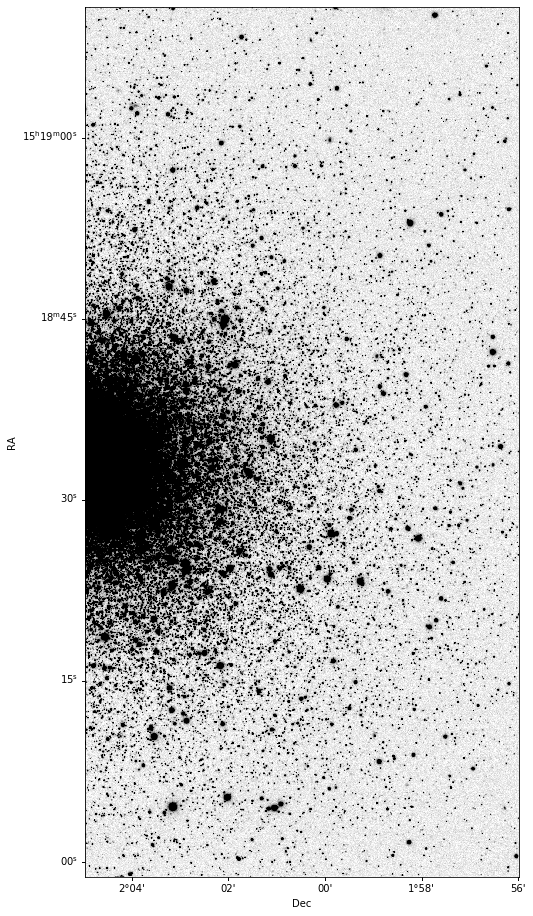

In [16]:
fig = plt.figure(figsize=(8,16))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
lon.set_axislabel('RA')
lat.set_axislabel('Dec')
lon.set_ticks_position('l') # need to specify location of axes because coordinate system is rotated 90 degrees from N up E left
lon.set_ticklabel_position('l')
lon.set_axislabel_position('l')
lat.set_ticks_position('b')
lat.set_ticklabel_position('b')
lat.set_axislabel_position('b')
plt.imshow(zimage,cmap=matplotlib.cm.gray_r,vmin=90,vmax=200)
zimage.shape

And here's a zoomed-in view.

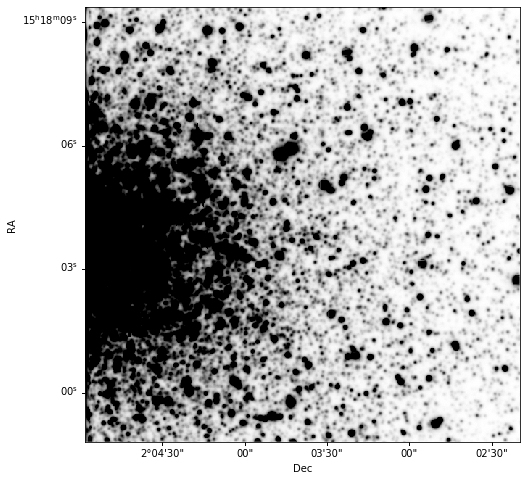

In [17]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
lon.set_axislabel('RA')
lat.set_axislabel('Dec')
lon.set_ticks_position('l')
lon.set_ticklabel_position('l')
lon.set_axislabel_position('l')
lat.set_ticks_position('b')
lat.set_ticklabel_position('b')
lat.set_axislabel_position('b')
plt.imshow(zimage[1700:2300,0:600],cmap=matplotlib.cm.gray_r,vmin=100,vmax=2000)

## Error Conditions <a id="errors" />
- Unknown query string params are ignored
- non-float SIZE

### Parameter error: Negative size given

In [18]:
#url=f'{baseurl}/vohdu?POS={ra},{dec}&SIZE=-1.0&limit=3&format=json'
#print(f'url={url}')
#requests.get(url).json()

apiurl=f'{baseurl}/vohdu?POS={ra},{dec}&SIZE=-1.0&limit=3&format=json'
response = requests.get(apiurl)
if response.status_code == 200:
    pp(response.content)
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use


b'[BADPRM] SIZE must be positive (got "-1.0")'


In [19]:
import datetime
elapsed = toc()
print(f'Elapsed seconds={elapsed}')
str(datetime.datetime.now())

Elapsed seconds=3.893776202996378


'2020-01-29 15:17:45.789000'

# Resources and references <a id="doc" />

[Simple Image Access Specification](http://www.ivoa.net/documents/latest/SIA.html) Version 1.0; IVOA Proposed Recommendation 21 Mai 2009

[dal API](http://marsnat2.pat.dm.noao.edu:8000/api-docs/#/dal)
We should look at fancy annotation to make this better. Programmers will want clear doc of what parameters can be passed to each service.

[Data  Models](https://marsnat2.pat.dm.noao.edu:8000/admin/doc/models/)

# Glossary <a id="glos">
    
Term     | Definition
---------|---------------------------------------------------------------------------------------------
ProcType | Processing Type; pipeline process used to generate reduced FITS from raw FITS